# elf1 perturbation simulation

Notebook for analyzing elf1 perturbation effects and regulatory circut

## Library imports

In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv
from regvelo import REGVELOVI

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.benchmarking import set_output
from rgv_tools.perturbation import (
    abundance_test,
    get_list_name,
    in_silico_block_simulation,
    inferred_GRN,
    RegulationScanning,
)

/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/home/icb/weixu.wang/miniconda3/envs/dynamo/lib/python3.10/site-packag

## General settings

In [2]:
%matplotlib inline

In [3]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Constants

In [4]:
DATASET = "zebrafish"

In [5]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

In [6]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [7]:
TERMINAL_STATES = [
    "mNC_head_mesenchymal",
    "mNC_arch2",
    "mNC_hox34",
    "Pigment",
]

## Data loading

In [8]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_run_regvelo.h5ad")

## elf1 perturbation simulation

### Model loading

In [9]:
model = DATA_DIR / DATASET / "processed" / "rgv_model"
vae = REGVELOVI.load(model, adata)
set_output(adata, vae)

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


### Calculate cell fate probabilities on original vector field

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:12:33,406 - INFO - Using pre-computed Schur decomposition


Defaulting to `'gmres'` solver.


  0%|          | 0/4 [00:00<?, ?/s]

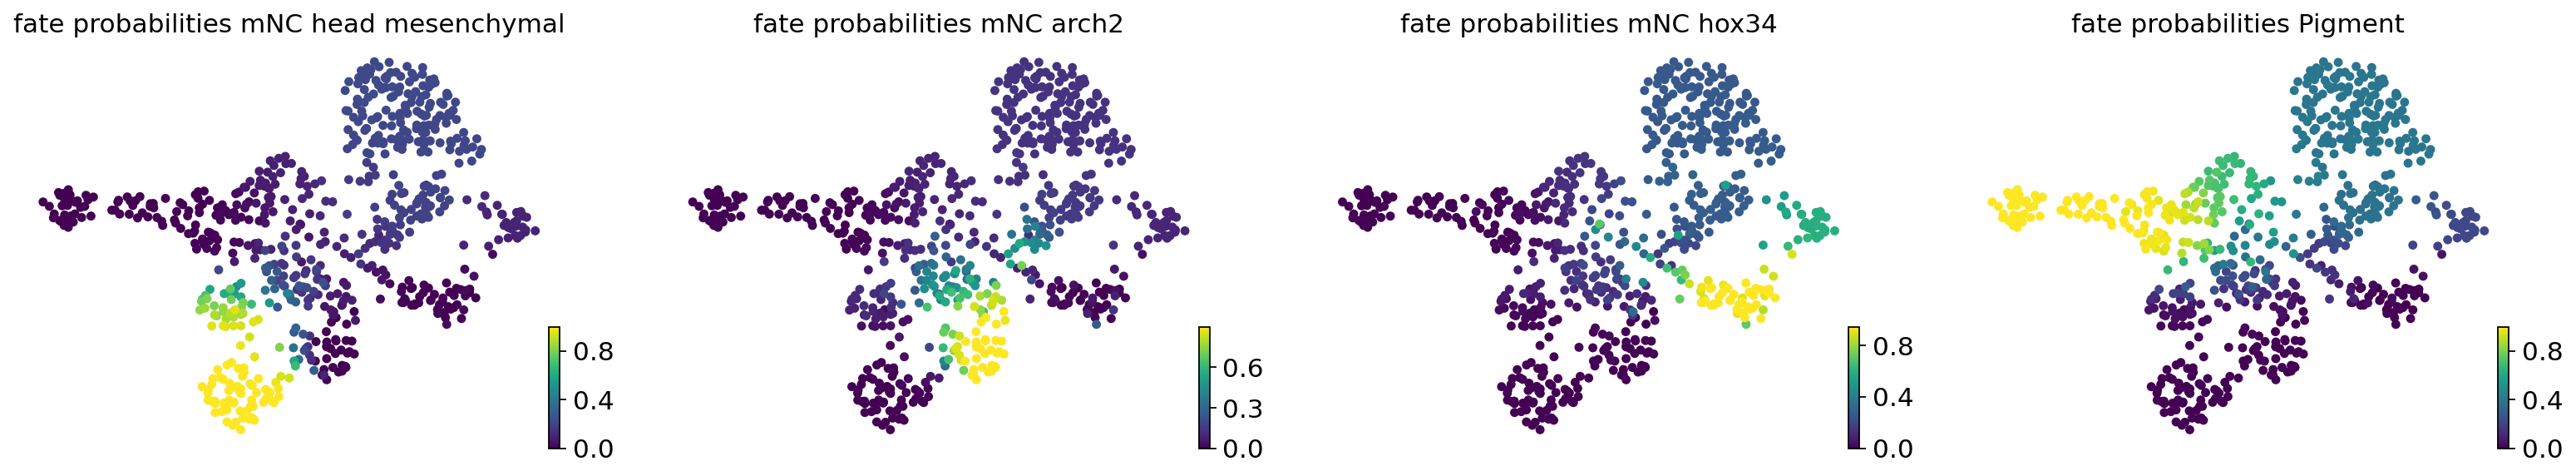

In [10]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
estimator = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
## evaluate the fate prob on original space
estimator.compute_macrostates(n_states=7, cluster_key="cell_type")
estimator.set_terminal_states(TERMINAL_STATES)
estimator.compute_fate_probabilities()
estimator.plot_fate_probabilities(same_plot=False)

### Calculate cell fate probabilities on perturbed vector field

In [11]:
adata_target_perturb, reg_vae_perturb = in_silico_block_simulation(model, adata, "elf1")

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


In [12]:
vk = cr.kernels.VelocityKernel(adata_target_perturb)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata_target_perturb).compute_transition_matrix()

estimator_p = cr.estimators.GPCCA(0.8 * vk + 0.2 * ck)
## evaluate the fate prob on original space
estimator_p.compute_macrostates(n_states=7, cluster_key="cell_type")
estimator_p.set_terminal_states(TERMINAL_STATES)
estimator_p.compute_fate_probabilities()
## visualize coefficient
cond1_df = pd.DataFrame(
    adata_target_perturb.obsm["lineages_fwd"], columns=adata_target_perturb.obsm["lineages_fwd"].names.tolist()
)
cond2_df = pd.DataFrame(adata.obsm["lineages_fwd"], columns=adata.obsm["lineages_fwd"].names.tolist())

## abundance test
data = abundance_test(cond2_df, cond1_df)
data = pd.DataFrame(
    {
        "Score": data.iloc[:, 0].tolist(),
        "p-value": data.iloc[:, 1].tolist(),
        "Terminal state": data.index.tolist(),
        "TF": ["elf1"] * (data.shape[0]),
    }
)

  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:12:42,665 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

In [13]:
final_df = data.copy()
final_df["Score"] = 0.5 - final_df["Score"]

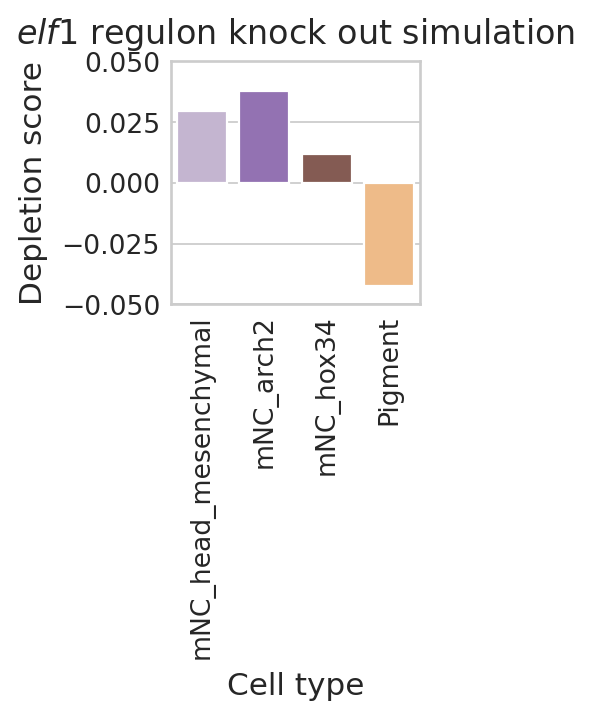

In [14]:
color_label = "cell_type"
df = pd.DataFrame(final_df["Score"])
df.columns = ["Depletion score"]
df["Cell type"] = final_df["Terminal state"]
order = df["Cell type"].tolist()

palette = dict(zip(adata.obs[color_label].cat.categories, adata.uns[f"{color_label}_colors"]))
subset_palette = {name: color for name, color in palette.items() if name in final_df.loc[:, "Terminal state"].tolist()}

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(2, 2))
    sns.barplot(
        data=df,
        y="Depletion score",
        x="Cell type",
        palette=subset_palette,
        order=order,
        ax=ax,
    )
    ax.set(ylim=(-0.05, 0.05))
    ax.tick_params(axis="x", rotation=90)
    plt.title("$\\mathit{" + "elf1" + "}$ regulon knock out simulation")

    if SAVE_FIGURES:
        plt.savefig(
            FIG_DIR / DATASET / "elf1_perturbation_simulation.svg", format="svg", transparent=True, bbox_inches="tight"
        )
    # Show the plot
    plt.show()

## GRN computation

In [15]:
GRN = inferred_GRN(vae, adata, label="cell_type", group="all", data_frame=True)

Computing global GRN...


### elf1 target screening

In [16]:
targets = GRN.loc[:, "elf1"]
targets = np.array(targets.index.tolist())[np.array(targets) != 0]

In [17]:
print("inferring perturbation...")
perturb_screening = RegulationScanning(model, adata, 7, "cell_type", TERMINAL_STATES, "elf1", targets, 0)
coef = pd.DataFrame(np.array(perturb_screening["coefficient"]))
coef.index = perturb_screening["target"]
coef.columns = get_list_name(perturb_screening["coefficient"][0])

inferring perturbation...
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:12:55,891 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:13:09,564 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done ENSDARG00000024966
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:13:22,520 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done ENSDARG00000042329
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:13:35,339 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done alcama
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:13:48,245 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done aopep
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:14:01,784 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done apc
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:14:15,353 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done atp6v0ca
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:14:28,892 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done baz1b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:14:43,256 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done calr3b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:14:56,582 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done ccny
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:15:10,068 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done cdk1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:15:23,049 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done cdkn1ca
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:15:35,974 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done celf2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:15:48,925 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done cenpf
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:16:01,766 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done cpeb4b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:16:15,175 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done cxxc5b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:16:29,623 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done diaph2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:16:42,563 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done dlg1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:16:56,979 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done dnajb2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:17:11,137 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done dnmt1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:17:24,700 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done dusp5
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:17:37,726 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done ebf3a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:17:51,116 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done emc2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:18:04,107 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done ephb3a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:18:17,957 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done erbb3b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:18:31,203 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done esco2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:18:44,101 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done ets1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:18:57,224 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done eva1ba
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:19:10,181 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done fam49a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:19:23,768 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done fhl3a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:19:37,305 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done fhod1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:19:51,016 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done fli1a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:20:04,057 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done foxo1a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:20:17,544 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done fzd3a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:20:31,331 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done glb1l
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:20:44,414 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done glulb
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:20:57,600 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done gpd2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:21:10,697 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done hat1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:21:24,392 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done hexb
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:21:38,170 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done hivep1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:21:51,188 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done hivep3b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:22:04,155 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done hmgn2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:22:17,260 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done hnrnpabb
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:22:30,930 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done hpcal4
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:22:43,842 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done hsp70.2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:22:57,057 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done hspa5
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:23:10,085 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done hspb8
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:23:23,254 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done id2a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:23:36,992 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done ildr2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:23:50,141 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done inka1a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:24:03,229 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done itga3a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:24:17,712 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done itga8
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:24:33,000 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done ivns1abpa
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:24:46,854 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done klf6a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:25:00,293 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done kntc1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:25:13,596 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done mbnl2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:25:26,944 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done metrn
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:25:40,431 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done mibp
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:25:53,708 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done myo10l1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:26:06,849 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done nr6a1b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:26:20,018 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done pcdh2g28
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:26:33,074 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done pdgfba
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:26:47,129 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done pdlim4
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:27:00,375 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done pleca
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:27:13,479 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done plpp3
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:27:26,802 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done pmp22a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:27:40,425 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done ppt1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:27:53,707 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done prdm1a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:28:06,761 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done prkceb
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:28:20,094 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done prkcsh
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:28:33,164 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done pttg1ipb
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:28:47,076 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done rabl6b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:29:00,421 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done ralgps2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:29:14,788 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done rgl1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:29:28,337 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done rhbdf1a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:29:41,513 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done rhoca
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:29:55,226 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done rxraa
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:30:08,472 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done sash1b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:30:21,732 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done sema3d
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:30:34,977 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done sema4ba
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:30:48,848 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done sept12
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:31:02,019 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done sept9a
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:31:15,226 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done serinc5
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:31:28,458 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done shroom4
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:31:41,715 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done si:ch211-199g17.2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:31:56,148 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done si:ch211-222l21.1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:32:09,345 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done si:ch73-335l21.1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:32:24,218 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done si:dkey-17m8.1
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:32:37,533 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done sipa1l2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:32:51,187 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done slbp
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:33:04,493 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done slc12a9
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:33:17,852 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done sox6
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:33:31,108 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done src
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:33:44,344 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done stat3
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:33:57,886 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done tcf12
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:34:11,078 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done tes
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:34:24,532 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done tle3b
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:34:37,771 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done tuba8l4
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:34:51,023 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done vash2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:35:04,245 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done vav2
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:35:17,376 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done zgc:154093
INFO     File /ictstr01/home/icb/weixu.wang/regulatory_velo/data/zebrafish/processed/rgv_model/model.pt already    
         downloaded                                                                                                


  0%|          | 0/697 [00:00<?, ?cell/s]

  0%|          | 0/697 [00:00<?, ?cell/s]

2024-11-25 17:35:30,736 - INFO - Using pre-computed Schur decomposition


  0%|          | 0/4 [00:00<?, ?/s]

Done zgc:165573


In [18]:
coef.sort_values("Pigment", ascending=False).iloc[:15,]

,mNC_head_mesenchymal,mNC_arch2,mNC_hox34,Pigment
fli1a,0.493243,0.474960,0.508461,0.514694
dnmt1,0.497401,0.490594,0.496920,0.509698
esco2,0.498142,0.487521,0.497025,0.509480
baz1b,0.497986,0.493608,0.496102,0.508951
hat1,0.500184,0.489740,0.495598,0.508426
si:ch73-335l21.1,0.497801,0.486049,0.499591,0.507288
cpeb4b,0.500248,0.491323,0.496722,0.506689
hivep1,0.498229,0.489174,0.499295,0.506637
metrn,0.499143,0.487146,0.499159,0.506189
vash2,0.498352,0.486737,0.501403,0.505310


In [19]:
Pigment = coef.sort_values(by="Pigment", ascending=False)[:15]["Pigment"]

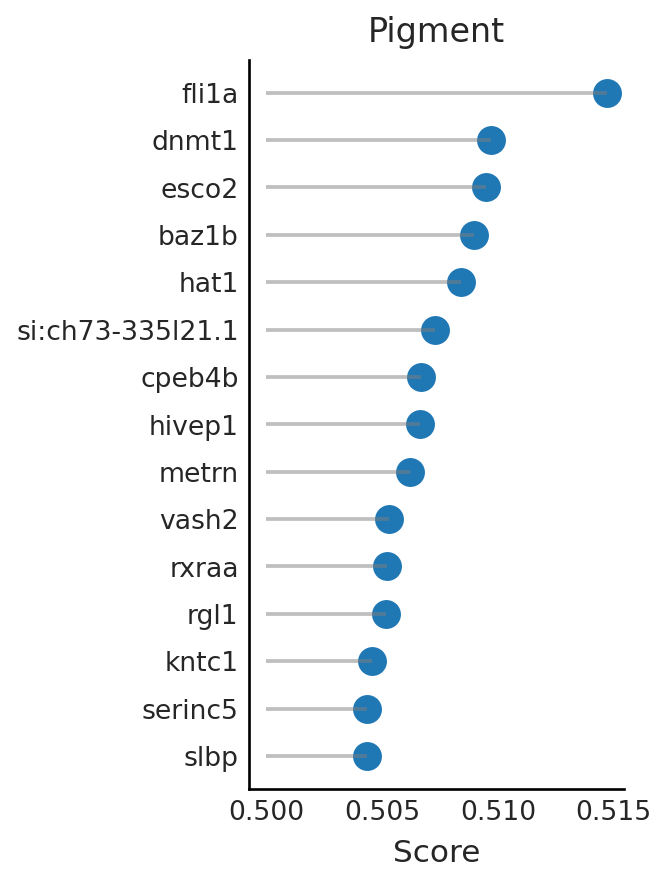

In [20]:
df = pd.DataFrame({"Gene": Pigment.index.tolist(), "Score": np.array(Pigment)})

# Sort DataFrame by -log10(p-value) for ordered plotting
df = df.sort_values(by="Score", ascending=False)

# Highlight specific genes
# Set up the plot
with mplscience.style_context():
    sns.set_style(style="white")
    fig, ax = plt.subplots(figsize=(3, 6))
    sns.scatterplot(data=df, x="Score", y="Gene", palette="purple", s=200, legend=False)

    for _, row in df.iterrows():
        plt.hlines(row["Gene"], xmin=0.5, xmax=row["Score"], colors="grey", linestyles="-", alpha=0.5)

    # Customize plot appearance
    plt.xlabel("Score")
    plt.ylabel("")
    plt.title("Pigment")

    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_color("black")
    plt.gca().spines["bottom"].set_color("black")
    # Show plot

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "elf1_driver.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()

## Activity of positive regulated genes

In [21]:
elf1_g = np.array(GRN.index.tolist())[np.array(GRN.loc[:, "elf1"]) != 0]
fli1a_g = np.array(GRN.index.tolist())[np.array(GRN.loc[:, "fli1a"]) != 0]

In [22]:
score = adata[:, elf1_g].layers["Ms"].mean(1) - adata[:, fli1a_g].layers["Ms"].mean(1)
score = scipy.stats.zscore(np.array(score))

In [23]:
sns.scatterplot(x=score, y=-adata.obs["latent_time"])
max_abs_x = max(abs(np.min(score)), abs(np.max(score)))
plt.xlim(-max_abs_x, max_abs_x)

# Display the plot
plt.axvline(0, color="grey", linestyle="--")  # Optional: add a vertical line at x=0 for clarity

In [24]:
adata.obsm["X_togglesiwtch"] = np.column_stack((score, -adata.obs["latent_time"]))

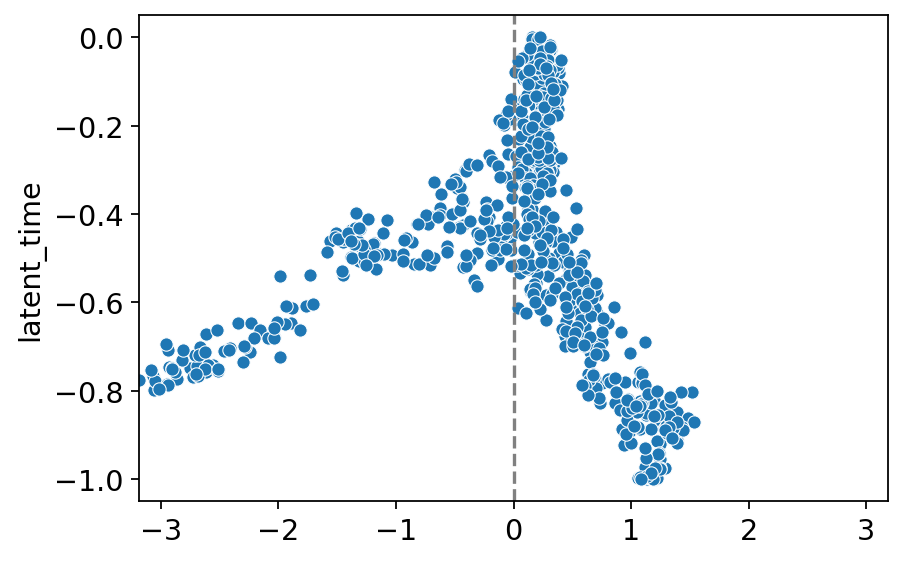

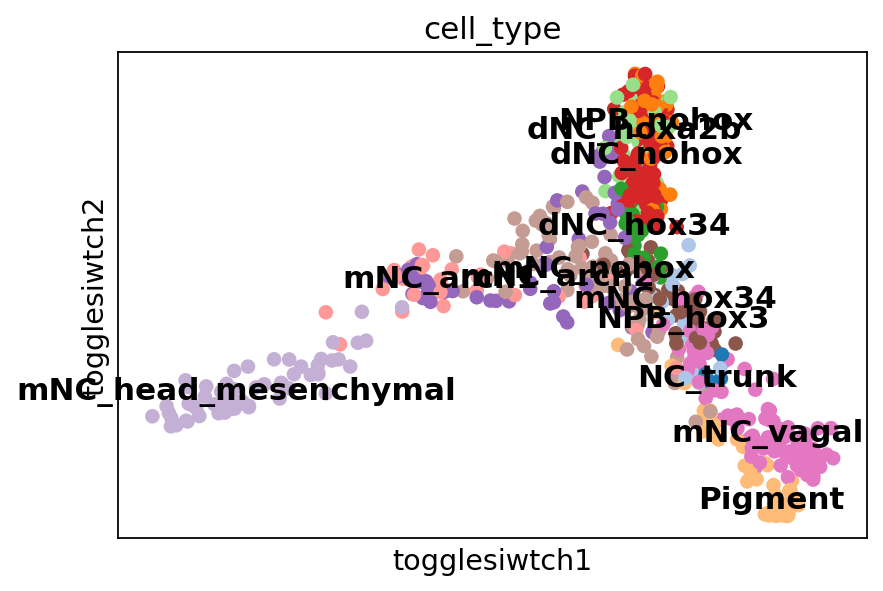

In [25]:
sc.pl.embedding(adata, basis="togglesiwtch", color="cell_type", palette=sc.pl.palettes.vega_20, legend_loc="on data")

In [26]:
adata.obs["ToggleState"] = [i if i in ["mNC_head_mesenchymal", "Pigment"] else np.nan for i in adata.obs["macrostates"]]
adata.obs["ToggleState"] = adata.obs["ToggleState"].astype("category")

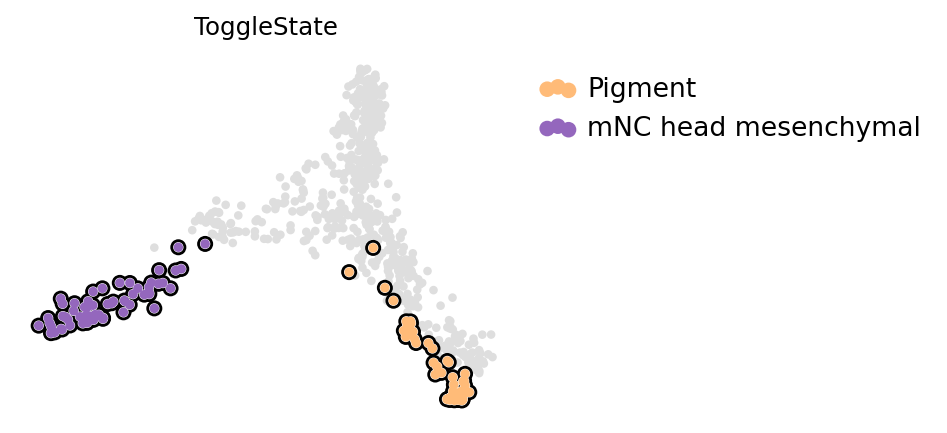

In [27]:
which = "ToggleState"
# adata.obs[which] = adata.obs["cell_type2"].copy()

state_names = adata.obs[which].cat.categories.tolist()
adata.obs[which] = adata.obs[which].astype(str).astype("category").cat.reorder_categories(["nan"] + state_names)

if which == "ToggleState":
    adata.uns[f"{which}_colors"] = ["#dedede"] + list(subset_palette.values())
else:
    adata.uns[f"{which}_colors"] = ["#dedede"] + list(subset_palette.values())
state_names = adata.obs[which].cat.categories.tolist()[1:]


with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(4, 3))
    scv.pl.scatter(adata, basis="togglesiwtch", c=which, add_outline=state_names, ax=ax, size=60)

    if SAVE_FIGURES:
        fig.savefig(FIG_DIR / DATASET / "fli1a_elf1.svg", format="svg", transparent=True, bbox_inches="tight")

In [28]:
if SAVE_DATA:
    adata.write_h5ad(DATA_DIR / DATASET / "results" / "elf1_screening.csv")